In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  
import matplotlib
import seaborn as sns
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import pandas as pd
import networkx as nx
import random
import operator

In [2]:
def atom_graph(g):
    # determine if subgroup is attached
    h = nx.Graph()
    v = []
    tris = {}
    edges = {}
    for node,data in g.nodes(data=True):
        g.node[node]['atoms'] = set([])

    for node,data in g.nodes(data=True):
        # triplet
        for node in nx.nodes(g):
            for each in g[node]:
                if each == node: continue
                neighbors = set(g[node]).intersection(set(g[each]))
                #print(node, each, neighbors, set(g[node]), g[each], set(g[each]))
                for neighbor in neighbors:
                    t = tuple(sorted((node, each, neighbor)))
                    if t not in list(tris.keys()):
                        nr = len(h.nodes())
                        tris[t] = nr
                        h.add_node(nr)
                        g.node[node]['atoms'].add(nr)
                        g.node[each]['atoms'].add(nr)
                        g.node[neighbor]['atoms'].add(nr)
                        print(node, each, neighbor)
                        for k in tris:
                            if len(set(k).intersection(set(t))) == 2:
                                h.add_edge(nr, tris[k])
                                edges[tuple(sorted(set(k).intersection(set(t))))] = nr

    if nx.cycle_basis(h):
        extra_nodes = set(h.nodes()).difference(set(np.concatenate(nx.cycle_basis(h))))
        for n in extra_nodes:
            h.remove_node(n)
    return h

def build_initial_pdb(h, pos):
    v = []
    count = 1
    atom_xyz = {}
    atom_names = {}
    line = "ATOM %6i %4s%4s%6i    %8.3f%8.3f%8.3f%6.2f%6.2f      %-4s\n"
    atomtype = 'C'
    residue = 'GP'
    resnr = 1
    x = 0
    y = 0
    z = 0
    bfactor = 0
    segment = 'GP'

    rot = lambda theta: np.matrix(((np.cos(np.radians(theta)), -np.sin(np.radians(theta)), 0), 
                                    (np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0),
                                    (0, 0, 0)))
    fp = open('junk.pdb', 'w')
    for i,node in enumerate(g.nodes()):
        atoms = g.node[node]['atoms']
        if not atoms: continue
        source = sorted(atoms)[0]
        u = np.array((1.39, 0, 0))
        theta = 0
        center = (0.0,0.0)
        
        for atom in sorted(atoms):
            if atom in atom_xyz: continue
            if atom not in pos: continue
            v = np.asarray(np.dot(u,rot(theta)))[0,:]
            x = v[0] + center[0]
            y = v[1] + center[1]
            x = pos[atom][0]/10
            y = pos[atom][1]/10

            atomtype = "C%d" % count
            atom_names[atom] = atomtype
            atomdata = (count,atomtype,residue,resnr,x,y,z,0.0,bfactor,segment[:4])
            atom_xyz[atom] = np.array((x,y,z))
            #print(line % atomdata)
            fp.write(line % atomdata)
            count += 1
            theta += 60
    fp.close()
    return atom_names

def build_topology(h, atom_names):
    v = []
    atom_names = {}
    count = 1
    fp = open('graphene.rtf', 'w')
    fp.write("""*  --------------------------------------------------------------------------  *
*          GRAPHENE                                                            *
*  --------------------------------------------------------------------------  *
*
36  1

MASS    23 HGR61    1.00800  ! aromatic H
MASS    61 CG2R61  12.01100  ! 6-mem aromatic C

DEFA FIRS NONE LAST NONE
AUTO ANGLES DIHE

RESI GP 0.0
""")
    for atom in h.nodes():
        if h.degree(atom) < 1: continue
        atom_names[atom] = "C%d" % count
        count += 1
        fp.write("ATOM %s CG2R61 0.0\n" % atom_names[atom])
        
    for atom_edge in h.edges():
        fp.write("BOND %s %s\n" % (atom_names[atom_edge[0]], atom_names[atom_edge[1]]))
    fp.close()

In [147]:
def add_unit(g, nodetype={'vertices': 6}):
    if len(g.nodes()) == 0:
        nodenr = 0
        g.add_node(0, nodetype)
    else:
        nodenr = max(g.nodes())+1
        g.add_node(nodenr, nodetype)
    return nodenr

def add_unit_neighbor(g, neighbor, nodetype={'vertices': 6}):
    if g.degree(neighbor) == g.node[neighbor]['vertices']:
        check_closure(g, neighbor)
        return False
    
    if random.random() <= 0.1 and g.node[neighbor]['vertices'] == 6:
        nodetype = {'vertices': 5}
        if random.random() < 0.5: nodetype = {'vertices': 7}
    
    near_hexagon = True
    nodenr = add_unit(g, nodetype)
    #neighbor = find_neighbor(g)
    g.add_edge(neighbor, nodenr)
    nn = find_neighbor_neighbor(g, nodenr, neighbor)
    if nn:
        g.add_edge(nodenr, nn)
        g.add_edge(neighbor, nn)
        if g.node[nn]['vertices'] != 6: near_hexagon = False
    
    if g.degree(neighbor) == g.node[neighbor]['vertices']:
        nn = find_neighbor_neighbor(g, nodenr, neighbor)
        if nn:
            g.add_edge(nodenr, nn)
            if g.node[nn]['vertices'] != 6: near_hexagon = False

    if not near_hexagon:
        g.node[nodenr]['vertices'] = 6

def find_neighbor(g):
    for n in g.nodes():
        if g.node[n]['vertices'] != g.degree(n):
            return n

def find_neighbor_neighbor(g, node, neighbor):
    neighbors = []
    for n in set(g[neighbor]):
        if n == node or g.node[n]['vertices'] == g.degree(n):
            continue
        shared_neighbors = set(g[n]).intersection(set(g[neighbor]))
        #print(node, neighbor, n, g[n], shared_neighbors)
        if len(shared_neighbors) < 2:
            neighbors.append(n)
    
    if neighbors:
        return neighbors[0]
    else:
        return None

def check_closure(g, node):
    h = g.subgraph(g[node])
    if nx.cycle_basis(h): return True
    sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
    nodes = [n[0] for n in sorted_nodes[:2] if n[1] == 1]
    if len(nodes) == 2:
        if g.node[nodes[0]]['vertices'] > g.degree(nodes[0]) and \
           g.node[nodes[1]]['vertices'] > g.degree(nodes[1]):
            g.add_edge(nodes[0], nodes[1])
            return False

        if g.node[nodes[0]]['vertices'] > g.degree(nodes[0]) and \
            g.node[nodes[1]]['vertices'] == g.degree(nodes[1]):
            h = g.subgraph(g[nodes[1]])
            sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
            xnode = [n[0] for n in sorted_nodes if n[1] == 1 and n[0] not in [nodes[0], nodes[1], node]].pop()
            for n in g[xnode]:
                if n in [nodes[1], node]: continue
                g.add_edge(nodes[0], n)
            g.remove_node(xnode)
            return False

        if g.node[nodes[0]]['vertices'] == g.degree(nodes[0]) and \
            g.node[nodes[1]]['vertices'] > g.degree(nodes[1]):
            h = g.subgraph(g[nodes[0]])
            sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
            xnode = [n[0] for n in sorted_nodes if n[1] == 1 and n[0] not in [nodes[0], nodes[1], node]].pop()
            for n in g[xnode]:
                if n in [nodes[0], node]: continue
                g.add_edge(nodes[1], n)
            g.remove_node(xnode)
            return False

In [177]:
g = nx.Graph()
add_unit(g)
closed_node = []
for i in range(150):
    node = find_neighbor(g)
    nodetype = g.node[node]['vertices']
    for j in range(nodetype):
        add_unit_neighbor(g, node)
    
    for n in g.nodes():
        if n not in closed_node and g.node[n]['vertices'] == g.degree(n):
            check_closure(g, n)
            closed_node.append(n)
#g.edges()

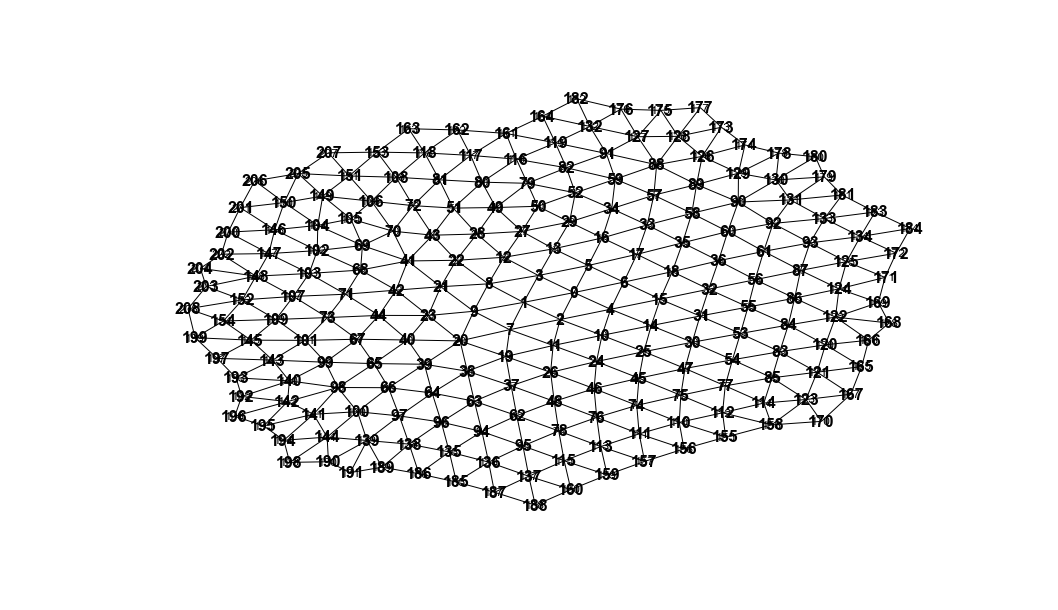

In [178]:
plt.figure(1,figsize=(14,8))
pos=nx.graphviz_layout(g, prog='neato')
#pos=nx.spring_layout(g)
nx.draw(g, pos, node_size=0, with_labels=True)
nx.draw_networkx_labels(g,pos,font_size=16,font_family='sans-serif',font_weight='bold')
plt.show()

In [180]:
h = atom_graph(g)
pos=nx.graphviz_layout(h, prog='neato')
atom_names = build_initial_pdb(h, pos)
build_topology(h, atom_names)

0 1 2
0 1 3
0 2 4
0 3 5
0 4 6
0 5 6
1 2 7
1 3 8
1 7 9
1 8 9
2 4 10
2 7 11
2 10 11
3 5 13
3 8 12
3 12 13
4 6 15
4 10 14
4 14 15
5 16 17
5 16 13
5 6 17
6 17 18
6 18 15
7 19 11
7 19 20
7 20 9
8 21 9
8 21 22
8 22 12
9 20 23
9 21 23
10 24 25
10 24 11
10 25 14
11 19 26
11 24 26
12 22 28
12 27 28
12 27 13
13 16 29
13 27 29
14 25 30
14 31 30
14 31 15
15 32 18
15 32 31
16 17 33
16 34 33
16 34 29
17 33 35
17 18 35
18 32 36
18 35 36
19 20 38
19 37 26
19 37 38
20 38 39
20 23 40
20 40 39
21 22 41
21 41 42
21 42 23
22 41 43
22 43 28
23 40 44
23 42 44
24 25 45
24 26 46
24 46 45
25 45 47
25 30 47
26 48 37
26 48 46
27 49 50
27 49 28
27 50 29
28 49 51
28 43 51
29 50 52
29 52 34
30 53 54
30 53 31
30 54 47
31 32 55
31 53 55
32 36 56
32 55 56
33 34 57
33 35 58
33 57 58
34 52 59
34 57 59
35 36 60
35 58 60
36 56 61
36 60 61
37 48 62
37 38 63
37 62 63
38 64 63
38 64 39
39 64 66
39 65 40
39 65 66
40 65 67
40 67 44
41 68 42
41 68 69
41 43 70
41 70 69
42 68 71
42 71 44
43 51 72
43 70 72
44 67 73
44 71 73
45 74 7

In [145]:
nside = 20

In [278]:
g = nx.Graph()
g.add_node(0, {'vertices': 6})
nodenr = 1

for i in range(nside):
    g.add_node(nodenr, {'vertices': 6})
    g.add_edge(nodenr-1, nodenr)
    nodenr += 1
edges = g.edges()
nodes = set(g.nodes())
allnodes = set(g.nodes())
firstrow = set(g.nodes())

def add_row(g, nbunch, addedge=False):
    nodenr = max(g.nodes())+1
    newnodes = []
    replace = []
    append = []
    edges = [edge for edge in g.edges(nbunch) if edge[0] in nbunch and edge[1] in nbunch]
    nodetype = {'vertices': 6}
    h = g.subgraph(nbunch)
    for i,edge in enumerate(edges):
        node0 = g.node[edge[0]]
        node1 = g.node[edge[1]]
        if set(nbunch).intersection(set(g[edge[0]]).intersection(g[edge[1]])): 
            #nn = set(nbunch).intersection(set(g[edge[0]]).intersection(g[edge[1]])).pop()
            #if h.degree(nn) < h.degree(edge[0]) or h.degree(nn) < h.degree(edge[1]):
            #    continue
            if h.degree(edge[0]) < len(set(g[edge[0]]).difference(newnodes)) and \
               h.degree(edge[1]) < len(set(g[edge[1]]).difference(newnodes)):
                print("skip", edge, h.degree(edge[0]) , g.degree(edge[0]), h.degree(edge[1]) ,g.degree(edge[1]))
                continue
        neighbors = [nn for nn in newnodes if nn != nodenr and (g.has_edge(nn, edge[0]) or g.has_edge(nn, edge[1]))]
        
        nodetype = {'vertices': 6}
        if node0['vertices'] == 6 and node1['vertices'] == 6:
            if random.random() <= 0.1:
                if random.random() < 0.5:
                    nodetype = {'vertices': 5}
                else:
                    nodetype = {'vertices': 7}
            if i > 0:
                for nn in neighbors:
                    if g.node[nn]['vertices'] != 6: nodetype = {'vertices': 6}
            if nodetype['vertices'] != 6: print(nodenr, nodetype)
            #nodetype = {'vertices': 6}
            #if nodenr == 36: nodetype = {'vertices': 5}
            #if nodenr == 20: nodetype = {'vertices': 7}
            #if nodenr == 40: nodetype = {'vertices': 7}
            #if nodenr == 45: nodetype = {'vertices': 5}
                
            #if nodenr == 37 or nodenr == 39:
            #    print(nodenr, edge)
            
            if g.degree(edge[0]) == node0['vertices'] or g.degree(edge[1]) == node1['vertices']:
                node = edge[1] if g.degree(edge[0]) == node0['vertices'] else edge[0]
                nodex = edge[0] if g.degree(edge[0]) == node0['vertices'] else edge[1]
                for nn in [nn for nn in newnodes if nn != nodenr and g.has_edge(nn, nodex)]:
                    g.add_edge(nn, node)
            else:
                g.add_node(nodenr, nodetype)
                newnodes.append(nodenr)
                g.add_edge(nodenr, edge[0])
                g.add_edge(nodenr, edge[1])
                for nn in neighbors:
                    try:
                        nnn = set(g[nn]).intersection(g[nodenr]).pop()
                    except:
                        continue
                    if g.degree(nnn) == 4 and nnn not in firstrow:
                        replace.append(nnn)
                        #append.append((nn, nodenr))
                        continue
                    if g.degree(nnn) == 5 and nnn not in firstrow:
                        print('5:', nnn, edge, neighbors)
                        node = [n for n in g[nnn] if n in newnodes and n != nodenr]
                        nodenr += 1
                        nodetype = {'vertices': 6}
                        g.add_node(nodenr, nodetype)
                        g.add_edge(nodenr, nnn)
                        g.add_edge(nodenr, nodenr-1)
                        newnodes.append(nodenr)
                        for nnn in node:
                            g.add_edge(nnn, nodenr)
                        continue
                    g.add_edge(nn, nodenr)
        else:
            if node0['vertices'] == 5 or node1['vertices'] == 5:
                n = edge[0] if node0['vertices'] == 5 else edge[1]
                if g.degree(n) == 5: continue
                    
                g.add_node(nodenr, nodetype)
                newnodes.append(nodenr)
                for node in edge:
                    if g.node[node]['vertices'] > g.degree(node):
                        g.add_edge(nodenr, node)
                    for nn in [nn for nn in newnodes if nn != nodenr and g.has_edge(nn, node)]:
                        g.add_edge(nn, nodenr)
                for nn in [nn for nn in g[n] if nn in nbunch]:
                    replace.append(nn)
                    g.add_edge(nn, nodenr)
                    
            if node0['vertices'] == 7 or node1['vertices'] == 7:
                n = edge[0] if node0['vertices'] == 7 else edge[1]
                g.add_node(nodenr, nodetype)
                newnodes.append(nodenr)
                g.add_edge(nodenr, edge[0])
                g.add_edge(nodenr, edge[1])
                for nn in neighbors:
                    g.add_edge(nn, nodenr)
                    
                if g.degree(n) == 6:
                    nn = [nn for nn in g[n] if nn in newnodes]
                    nodenr += 1
                    nodetype = {'vertices': 6}
                    g.add_node(nodenr, nodetype)
                    g.add_edge(nodenr, n)
                    newnodes.append(nodenr)
                    for nnn in nn:
                        g.add_edge(nnn, nodenr)
                    g.remove_edge(nn[0], nn[1])
                    
                    nodenr += 1
                    nodetype = {'vertices': 6}
                    newnodes.append(nodenr)
                    g.add_node(nodenr, nodetype)
                    g.add_edge(nodenr, nodenr-1)
                    g.add_edge(nodenr, nn[0])

        nodenr += 1
    
    if addedge:
        sorted_nodes = sorted(g.degree(nbunch).items(), key=operator.itemgetter(1))
        for i in range(2):
            neighbors = set(g[sorted_nodes[i][0]]).intersection(set(nbunch).union(set(newnodes)))
            if len(neighbors) == 4:
                continue
            #if g.node[sorted_nodes[i][0]]['vertices'] == 6 and g.degree(sorted_nodes[i][0]) == 4: continue
            nodetype = {'vertices': 6}
            g.add_node(nodenr, nodetype)
            newnodes.append(nodenr)

            g.add_edge(nodenr, sorted_nodes[i][0])
            for k in g[sorted_nodes[i][0]]:
                if k in newnodes and k != nodenr:
                    g.add_edge(nodenr, k)
            nodenr += 1

    if replace:
        for n in replace:
            if g.degree(n) == g.node[n]['vertices']: continue
            nodetype = {'vertices': 6}
            g.add_node(nodenr, nodetype)
            for nn in g[n]:
                g.add_edge(nodenr, nn)
            g.remove_node(n)
            newnodes.append(nodenr)
            nodenr += 1
    
    if append:
        for edge in append:
            node = set(g[edge[0]]).intersection(g[edge[1]]).pop()
            nodetype = {'vertices': 6}
            g.add_node(nodenr, nodetype)
            g.add_edge(nodenr, edge[0])
            g.add_edge(nodenr, edge[1])
            g.add_edge(nodenr, node)
            newnodes.append(nodenr)
            g.remove_edge(edge[0], edge[1])
            nodenr += 1
    
    h = g.subgraph(newnodes)
    for node in g.nodes():
        if g.node[node]['vertices'] == g.degree(node):
            h = g.subgraph(g[node])
            if len(nx.cycle_basis(h)) < 1:
                sorted_nodes = sorted(h.degree().items(), key=operator.itemgetter(1))
                ends = sorted_nodes[:2]
                g.add_edge(ends[0][0], ends[1][0])

    for node in g.nodes():
        if g.degree(node) == 1: g.remove_node(node)
    return g

#for n in nodes:
#    print(n, g.node[n]['vertices'])
    
for i in range(10):
    addedge = False
    if len(nodes) <= nside: addedge = True
    add_row(g, nodes, addedge)
    #nodes = [n for n in g.nodes() if g.degree(n) != g.node[n]['vertices']]
    nodes = set(g.nodes()).difference(allnodes)
    allnodes = allnodes.union(nodes)
    #for n in nodes:
    #    connected = False
    #    for nn in nodes:
    #        if g.has_edge(n, nn): 
    #            connected = True
    #            break
    #    if not connected:
    #        nodes = nodes - set((nn,))
    #if len(nodes) < nside and addedge:
    #    for n in nodes:
    #        for nn in g[n]:
    #            if g.node[nn]['vertices'] > g.degree(nn):
    #                nodes.append(nn)
    #            if len(nodes) == nside: break
    #        if len(nodes) == nside: break
    print(i, nodes)
    #for n in nodes:
    #    print(n, g.node[n]['vertices'])

#print(len(g.edges()))
#print(g.degree())

0 {32, 33, 34, 35, 36, 37, 38, 39, 40, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
46 {'vertices': 7}
48 {'vertices': 5}
1 {41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61}
72 {'vertices': 7}
73 {'vertices': 5}
78 {'vertices': 5}
80 {'vertices': 5}
2 {64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 62, 63}
skip (67, 69) 3 6 3 4
94 {'vertices': 5}
3 {96, 97, 98, 99, 100, 101, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95}
106 {'vertices': 5}
5: 91 (90, 91) [108, 115]
4 {102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120}
skip (102, 118) 2 6 3 6
skip (102, 105) 2 6 4 6
skip (105, 118) 4 6 3 6
skip (105, 110) 4 6 3 5
skip (110, 118) 3 6 3 6
128 {'vertices': 7}
131 {'vertices': 5}
5: 117 (116, 117) [125, 131]
5 {128, 129, 130, 131, 132, 133, 134, 135, 136, 122, 123, 124, 125, 126, 127}
5: 133 (133, 125) [144]
6 {137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153}
ski

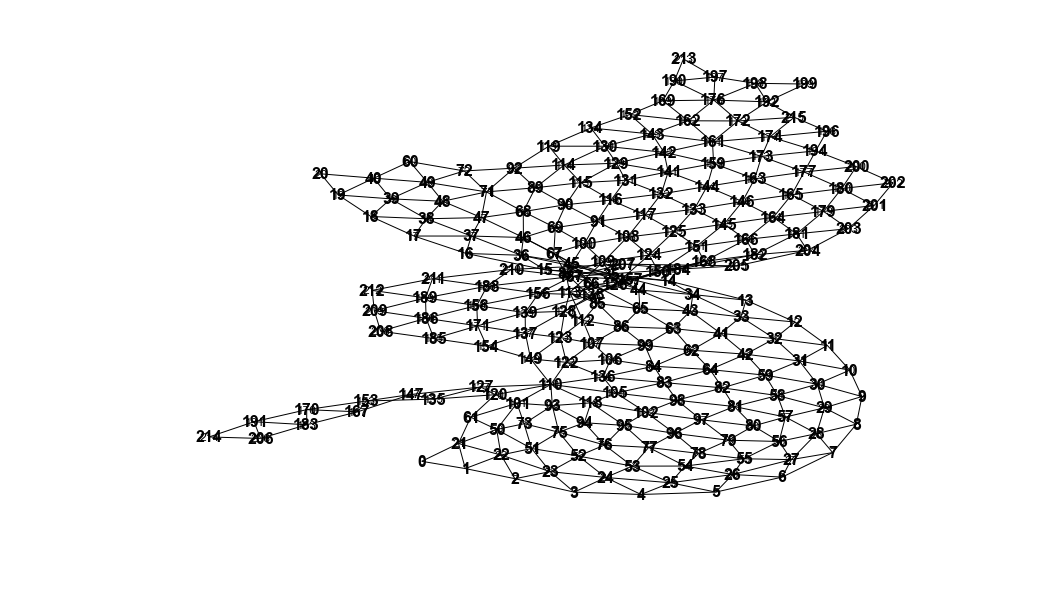

In [279]:
plt.figure(1,figsize=(14,8))
pos=nx.graphviz_layout(g, prog='neato')
#pos=nx.spring_layout(g)
nx.draw(g, pos, node_size=0, with_labels=True)
nx.draw_networkx_labels(g,pos, font_size=16,font_family='sans-serif',font_weight='bold')
plt.show()

In [266]:
print(g.node[210])
print(g[210])


{'vertices': 6}
{209: {}, 184: {}, 217: {}, 234: {}, 236: {}, 190: {}}


In [267]:
# determine if subgroup is attached
h = nx.Graph()
v = []
tris = {}
edges = {}
for node,data in g.nodes(data=True):
    g.node[node]['atoms'] = set([])

# triplet
for node in nx.nodes(g):
    for each in g[node]:
        if each == node: continue
        neighbors = set(g[node]).intersection(set(g[each]))
        #print(node, each, neighbors)
        for neighbor in neighbors:
            t = tuple(sorted((node, each, neighbor)))
            if t not in list(tris.keys()):
                nr = len(h.nodes())
                tris[t] = nr
                h.add_node(nr)
                g.node[node]['atoms'].add(nr)
                g.node[each]['atoms'].add(nr)
                g.node[neighbor]['atoms'].add(nr)
                #print(node, each, neighbor)
                for k in tris:
                    if len(set(k).intersection(set(t))) == 2:
                        #x = (set(k) - set(t)).pop()
                        #y = (set(t) - set(k)).pop()
                        h.add_edge(nr, tris[k])
                        edges[tuple(sorted(set(k).intersection(set(t))))] = nr

#for node,data in g.nodes(data=True):
#    g.node[node]['atoms'] = set([])
#dfs(0, 0)
#for node,data in g.nodes(data=True):
#    print(node,data)
for n in set(h.nodes()).difference(set(np.concatenate(nx.cycle_basis(h)))):
    h.remove_node(n)

for edge in nx.edges(g):
    break
    if tuple(sorted(edge)) not in edges:
        nr = len(h.nodes())
        h.add_node(nr)
        g.node[edge[0]]['atoms'].add(nr)
        g.node[edge[1]]['atoms'].add(nr)
        edges[tuple(sorted(edge))] = nr
        for k in tris:
            if len(set(k).intersection(set(edge))) == 2:
                h.add_edge(nr, tris[k])

for node,data in g.nodes(data=True):
    break
    print(node, data)
    if len(data['atoms']) < data['vertices']:
        nr = len(h.nodes())
        n = data['vertices']-len(data['atoms'])
        ends = sorted(h.subgraph(data['atoms']).degree().items(), key=operator.itemgetter(1))[:2]
        #print(node, data)
        h.add_edge(ends[0][0], nr)
        g.node[node]['atoms'].add(nr)
        for i in range(1,n):
            h.add_edge(nr, nr+1)
            nr += 1
            g.node[node]['atoms'].add(nr)
        h.add_edge(nr, ends[1][0])
        
for node,data in g.nodes(data=True):
    break
    if len(h.subgraph(data['atoms']).edges()) < data['vertices']:
        nr = len(h.nodes())
        n = data['vertices']-len(h.subgraph(data['atoms']).edges())
        ends = sorted(h.subgraph(data['atoms']).degree().items(), key=operator.itemgetter(1))[:2]
        h.add_edge(ends[0][0], ends[1][0])
        print('x')
    
    #print(node, data)
#print(len(h.edges()))

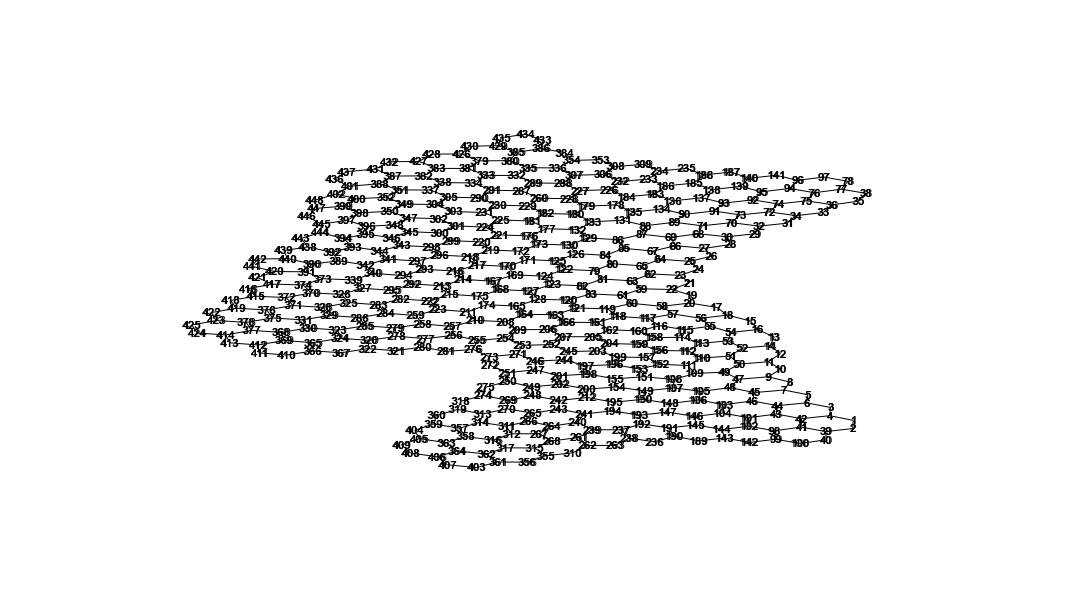

In [268]:
plt.figure(1,figsize=(14,8))
pos=nx.graphviz_layout(h, prog='neato')
#pos=nx.spring_layout(g)
nx.draw(h, pos, node_size=0, with_labels=True)
nx.draw_networkx_labels(h,pos, font_size=11,font_family='sans-serif',font_weight='bold')
plt.show()

In [48]:
v = []
count = 1
atom_xyz = {}
atom_names = {}
line = "ATOM %6i %4s%4s%6i    %8.3f%8.3f%8.3f%6.2f%6.2f      %-4s\n"
atomtype = 'C'
residue = 'GP'
resnr = 1
x = 0
y = 0
z = 0
bfactor = 0
segment = 'GP'

rot = lambda theta: np.matrix(((np.cos(np.radians(theta)), -np.sin(np.radians(theta)), 0), 
                                (np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0),
                                (0, 0, 0)))
fp = open('junk.pdb', 'w')
for i,node in enumerate(g.nodes()):
    atoms = g.node[node]['atoms']
    source = sorted(atoms)[0]
    u = np.array((1.39, 0, 0))
    theta = 0
    center = (0.0,0.0)
    
    for atom in sorted(atoms):
        if atom in atom_xyz: continue
        if atom not in pos: continue
        v = np.asarray(np.dot(u,rot(theta)))[0,:]
        x = v[0] + center[0]
        y = v[1] + center[1]
        x = pos[atom][0]/10
        y = pos[atom][1]/10

        atomtype = "C%d" % count
        atom_names[atom] = atomtype
        atomdata = (count,atomtype,residue,resnr,x,y,z,0.0,bfactor,segment[:4])
        atom_xyz[atom] = np.array((x,y,z))
        #print(line % atomdata)
        fp.write(line % atomdata)
        count += 1
        theta += 60
fp.close()

KeyError: 'atoms'

In [270]:
v = []
atom_names = {}
count = 1
fp = open('graphene.rtf', 'w')
fp.write("""*  --------------------------------------------------------------------------  *
*          GRAPHENE                                                            *
*  --------------------------------------------------------------------------  *
*
36  1

MASS    23 HGR61    1.00800  ! aromatic H
MASS    61 CG2R61  12.01100  ! 6-mem aromatic C

DEFA FIRS NONE LAST NONE
AUTO ANGLES DIHE

RESI GP 0.0
""")
for atom in h.nodes():
    atom_names[atom] = "C%d" % count
    count += 1
    fp.write("ATOM %s CG2R61 0.0\n" % atom_names[atom])
    
for atom_edge in h.edges():
    fp.write("BOND %s %s\n" % (atom_names[atom_edge[0]], atom_names[atom_edge[1]]))
fp.close()